In [37]:
#nba_api is an API Client for www.nba.com. This package is meant to make the API Endpoints more accessible and to provide extensive documentation.
#The APIs on www.nba.com are largely undocumented and change frequently.

import os
import requests
import pandas as pd
import json
import hvplot.pandas
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import panel as pn

from dotenv import load_dotenv
from matplotlib import rcParams

%matplotlib "inline"

In [38]:
from nba_api.stats.static import players
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import NumberOfGames, SeasonAll, SeasonTypeAllStar, LeagueIDNullable

In [39]:
#extracting raw data using nba_api package
player_dict = players.get_players()
teams = teams.get_teams()

#converting both dictionaries into Dataframes
team = pd.DataFrame(teams)
player = pd.DataFrame(player_dict)

#to check if there are any null values in the raw data
player.isnull().sum(), team.isnull().sum()

(id            0
 full_name     0
 first_name    0
 last_name     0
 is_active     0
 dtype: int64,
 id              0
 full_name       0
 abbreviation    0
 nickname        0
 city            0
 state           0
 year_founded    0
 dtype: int64)

In [40]:
#Develop a few functions to smoothen out our data extraction process
#First step: Figuring out a team/player ID via function player_id("Player's Name") or team_ID(Team's Name)
#Second step: Using the ID as inputs for functions like:
#             1) game_log(playerid, season) - extracts nba data of an nba player within a specific season
#             1) all_season_log(playerid) - extracts all seasons' nba data of the nba player
#             1) bkb_teamlog(playerid, season) - extracts nba data of an nba_team

def player_id(playername):
    player = [player for player in player_dict if player['full_name'] == playername][0]
    player_id = player['id']
    return player_id

#getting team's ID
#how to use function: player_id("Team's Name") 
#for example: team_id('Golden State Warriors')
def team_id(teamname):
    team_find = [x for x in teams if x['full_name'] == teamname][0]
    team_id_no = team_find['id']
    return team_id_no

#creating a function to get player's data from specific year
#type game_log(playerID, season's year)
#for example: game_log(2544,2018)

def game_log(playerid,season):
    player_gamelog = playergamelog.PlayerGameLog(player_id = playerid, season = season)
    df_games = player_gamelog.get_data_frames()
    return df_games[0]

#creating a function to get a player's lifetime career in basketball
#type all_season_log(playerID using earlier function)
def all_season_log(playerid):
    gamelog_bron_all = playergamelog.PlayerGameLog(player_id = playerid, season = SeasonAll.all)
    df_bron_games_all = gamelog_bron_all.get_data_frames()
    return df_bron_games_all[0]

#creating a function to get a team's stats in basketball
#type bkb_teamlog(Team's ID using earlier function)

def bkb_teamlog(teamid):
    team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable = teamid).get_data_frames()[0]
    return team_games

#Summary: 
# 1) player_id('Player's Name')
# 2) team_id('Team's Name')
# 3) game_log(playerid,season)
# 4) all_season_log(playerid)
# 5) bkb_teamlog(teamid)

In [41]:
bron_id = player_id('LeBron James')
chris_id = player_id('Chris Paul')
james_id = player_id('James Harden')

print(f"Lebron ID      : {bron_id}")
print(f"Chris Paul ID  : {chris_id}")
print(f"James Harden ID: {james_id}")

a = team_id('Cleveland Cavaliers')
b = team_id('Los Angeles Lakers')
c = team_id('Miami Heat')

print(f"Cleveland Cavaliers Team ID :{a}")
print(f"Los Angeles Lakers Team ID  :{b}")
print(f"Miami Heat Team ID          :{c}")

#'Cleveland Cavaliers', 'Los Angeles Lakers','Miami Heat'

Lebron ID      : 2544
Chris Paul ID  : 101108
James Harden ID: 201935
Cleveland Cavaliers Team ID :1610612739
Los Angeles Lakers Team ID  :1610612747
Miami Heat Team ID          :1610612748


In [42]:
#To extract team's raw data from a specific date

def team_raw_data(start_date, end_date, teamid):
    team_raw_data = bkb_teamlog(teamid)
    range = (team_raw_data['GAME_DATE'] >= start_date) & (team_raw_data['GAME_DATE'] <= end_date)
    date_extract_data = team_raw_data.loc[range]
    return date_extract_data

In [43]:
#without Lebron
cavs_DF1 = team_raw_data('1999-02-02','2003-04-16',1610612739)
miami_DF = team_raw_data('2004-11-02','2009-04-15',1610612748)
cavs_DF2 = team_raw_data('2007-10-30','2013-04-17',1610612739)
la_lakers_before_lebron = team_raw_data('2014-10-28','2018-04-11',1610612747)

#with Lebron
cavs_DF1_withlebron = team_raw_data('2003-10-28','2010-01-01',1610612739)
miami_DF_withlebron = team_raw_data('2010-10-26','2014-04-16',1610612748)
cavs_DF2_withlebron = team_raw_data('2014-10-28','2018-04-11',1610612739)
la_lakers_DF_withlebron = team_raw_data('2018-10-16','2022-04-04',1610612747)


In [44]:
#Use this function for dataframe extraction
#dataframe = DFs we have extracted above
#team_name = Just put in the team's name which you wanna label the DF with

def nba_analysis(dataframe,team_name):
    #remove duplications
    dataframe = dataframe.drop_duplicates(['GAME_ID'])
    #Extracting only "Years" from "GAME_DATE"
    dataframe['Year'] = pd.DatetimeIndex(dataframe['GAME_DATE']).year
    team_DF = dataframe

    #Including columns with important parameters
    a = team_DF.loc[:,['TEAM_NAME','GAME_DATE', 'Year', 'PTS','WL']]
    
    #Isolating PTS column and taking the average of all PTS
    main_DF = a.rename(columns={"PTS": "Mean PTS"})
    mean_DF = main_DF.groupby("Year").mean().reset_index()
    
    #Isolating PTS column and taking the sum of all PTS
    main_DF2 = a.rename(columns={"PTS": "Sum PTS"})
    sum_DF = main_DF2.groupby("Year").sum().reset_index()
    
    #creating for loop condition (years = [2012,2013,2014, ...])
    years = mean_DF['Year'].tolist()
    
    #creating empty dataframes for winrate% & wincounts
    team_winrate = []
    team_wincount = []
   
    #creating for loop to append yearly SD and winrate% into the empty dataframes
    for year in years:    
        b = team_DF.loc[team_DF['Year'] == year]
        lal_WR = b['WL'].to_list()
        winrate_pct = (lal_WR.count('W')/len(lal_WR))*100
        team_winrate.append(winrate_pct)
        
        c = team_DF.loc[team_DF['Year'] == year]
        lal_WR = c['WL'].to_list()
        wincount = lal_WR.count('W')
        team_wincount.append(wincount)
    
    #creating individual yearly dataframes for winrate and wincount
    WR_DF = pd.DataFrame(team_winrate) 
    WR_DF['Year'] = years
    WR_DF = WR_DF.set_index('Year').rename(columns={0: 'WR'})

    WR_counts = pd.DataFrame(team_wincount) 
    WR_counts['Year'] = years
    WR_counts = WR_counts.set_index('Year').rename(columns={0: 'Win Counts'})
    
    #concatenate both mean & SD values on the same dataframe
    #set year as index so DF can be concat. properly
    mean_DF = mean_DF.set_index("Year")
    sum_DF = sum_DF.set_index("Year")
    main_DF = pd.concat([mean_DF, sum_DF, WR_DF, WR_counts], axis='columns')
    
    #Adding Team's Name onto dataframe
    main_DF['Team Name'] = team_name
    
    #formating data into their appropriate format 
    main_DF = np.round(main_DF, decimals=2)
    
    return main_DF

In [45]:
#output example of nba_analysis function
nba_analysis(cavs_DF1, "Cleveland Caveliers 1")

,Mean PTS,Sum PTS,WR,Win Counts,Team Name
Year,,,,,
1999,90.97,7187,43.04,34,Cleveland Caveliers 1
2000,94.44,7650,44.44,36,Cleveland Caveliers 1
2001,92.27,7751,30.95,26,Cleveland Caveliers 1
2002,94.58,8039,27.06,23,Cleveland Caveliers 1
2003,92.10,4513,22.45,11,Cleveland Caveliers 1


In [46]:
#concatenating with and without lebron

cavs_DF1 = pd.concat([nba_analysis(cavs_DF1, "Cleveland Caveliers 1"),nba_analysis(cavs_DF1_withlebron,"Cleveland Caveliers 1")],axis='rows')
cavs_DF2 = pd.concat([nba_analysis(cavs_DF2,"Cleveland Caveliers 2"),nba_analysis(cavs_DF2_withlebron,"Cleveland Caveliers 2")],axis='rows')
miami_DF1 = pd.concat([nba_analysis(miami_DF,"Miami Heat"),nba_analysis(miami_DF_withlebron,"Miami Heat")],axis='rows')
lakers_DF1 = pd.concat([nba_analysis(la_lakers_before_lebron,"Los Angeles Lakers"),nba_analysis(la_lakers_DF_withlebron,"Los Angeles Lakers")],axis='rows')

#concatenating all 4 dataframes into 1
four_teams_DF = pd.concat([cavs_DF1,cavs_DF2,miami_DF1,lakers_DF1],axis='rows')

four_teams_DF.head(30)
#output to csv
four_teams_DF.to_csv("All Team Stats with and without LeBron.csv")

C:\Users\dhaam\anaconda3\envs\dev\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [33]:
#isolating specific parameters for graph plotting

winrate_DF = four_teams_DF.loc[:, ["WR","Team Name"]]
sum_PTS_DF = four_teams_DF.loc[:, ["Sum PTS","Team Name"]]
mean_PTS_DF = four_teams_DF.loc[:, ["Mean PTS","Team Name"]]

#Graph plots
winrate_plot = winrate_DF.hvplot.line(title="Team's Yearly Winrate%", xlabel="Year",ylabel="WR",groupby = "Team Name", rot=90,height=400, width=500,color='c')
sum_plot = sum_PTS_DF.hvplot.bar(title="Team's Yearly Total Points Scored", xlabel="Year",ylabel="Sum PTS",groupby = "Team Name", rot=90,height=400, width=500,color='c')
mean_plot = mean_PTS_DF.hvplot.bar(title="Team's Yearly Total Mean Score", xlabel="Year",ylabel="Mean PTS",groupby = "Team Name", rot=90,height=400, width=500,color='c')

#Setting up Tabs
nba_dashboard = pn.Tabs(
    ("Winrate Analysis", winrate_plot),
    ("Sum Points Analysis", sum_plot),
    ("Mean Points Analysis", mean_plot))

nba_dashboard

Tabs
    [0] Row(name='Winrate Analysis')
        [0] HoloViews(DynamicMap, name='Winrate Analysis')
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 20, 20), name='Team Name', options=['Cleveland Caveliers 1', ...], value='Cleveland Caveliers 1', width=250)
            [1] VSpacer()
    [1] Row(name='Sum Points Analysis')
        [0] HoloViews(DynamicMap, name='Sum Points Analysis')
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 20, 20), name='Team Name', options=['Cleveland Caveliers 1', ...], value='Cleveland Caveliers 1', width=250)
            [1] VSpacer()
    [2] Row(name='Mean Points Analysis')
        [0] HoloViews(DynamicMap, name='Mean Points Analysis')
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 20, 20), name='Team Name', options=['Cleveland Caveliers 1', ...], value='Cleveland Caveliers 1', width=250)
            [1] VSpacer()

In [34]:
#function to extract player impact score (team_df = df extracted in previous section ; player_id = player's ID)

def player_impact_function(team_dataframe, player_id):
    #extract player's lifetime career data
    team_df = team_dataframe.drop_duplicates(['GAME_ID'])
    player_data = all_season_log(player_id).rename(columns={'Game_ID': 'GAME_ID'})
    
    #changing dataframe's header to prep for concat process
    team_raw_data = team_df.loc[:,['GAME_ID', 'PTS']].rename(columns={'PTS': 'Team PTS'}).set_index("GAME_ID")
    player_data = player_data.set_index("GAME_ID")

    #join player's data with team's data based on GAME_ID
    Q2_main_DF = pd.concat([player_data, team_raw_data], axis='columns', join='inner')
    df = Q2_main_DF.reset_index()
    game_id = df['GAME_ID'].tolist()
    
    #create an empty dataframe so we could append calculated player's impact score into a list
    game_df = []
    
    #Creating a for loop to calculate player's impact score for each game (gameID) within the dataframe
    #Player Impact Score = PTS + 0.4 * FG - 0.7 * FGA - 0.4*(FTA - FT) + 0.7 * ORB + 0.3 * DRB + STL + 0.7 * AST + 0.7 * BLK - 0.4 * PF - TOV
    for id in game_id:
        player_impact = Q2_main_DF.loc[id,"PTS"] 
        + 0.4*Q2_main_DF.loc[id,"FGM"] 
        - 0.7*Q2_main_DF.loc[id,"FGA"]
        - 0.4*((Q2_main_DF.loc[id,"FTA"]-Q2_main_DF.loc[id,"FTM"]))
        + 0.7*Q2_main_DF.loc[id,"OREB"]
        + 0.3*Q2_main_DF.loc[id,"DREB"]
        + Q2_main_DF.loc[id,"STL"]
        + 0.7*Q2_main_DF.loc[id,"AST"]
        + 0.7*Q2_main_DF.loc[id,"BLK"]
        - 0.4*Q2_main_DF.loc[id,"PF"]
        - Q2_main_DF.loc[id,"TOV"]
        game_df.append(player_impact)
    
    player_impact_list = game_df   
    #creating a column for player's impact score and append list onto the dataframe
    Q2_main_DF['player_impact_score'] = player_impact_list
    player_impact_DF = Q2_main_DF.loc[:,["player_impact_score", "Team PTS"]]
    return player_impact_DF

In [35]:
#data prep for graph plots
#pis = player impact score
lebron_cavsDF1_pis = player_impact_function(cavs_DF1_withlebron, 2544)
lebron_cavsDF2_pis = player_impact_function(cavs_DF2_withlebron, 2544)
lebron_miami_pis = player_impact_function(miami_DF_withlebron, 2544)
lebron_lakers_pis = player_impact_function(la_lakers_DF_withlebron, 2544)

Text(0.5, 1.0, 'Lebron in Lakers')

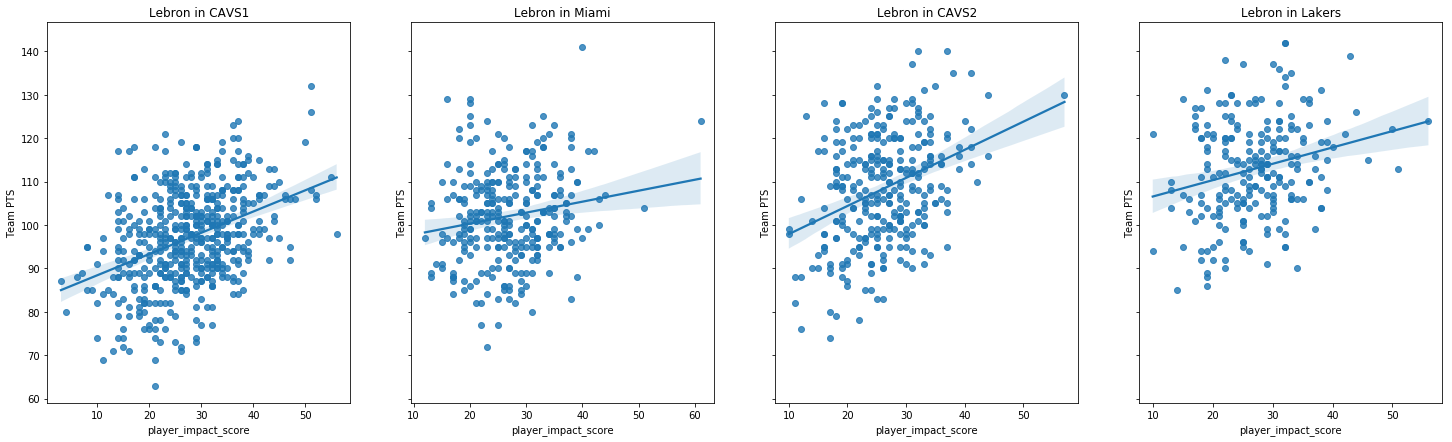

In [36]:
#graph plots

rcParams['figure.figsize'] = 25,7
fig, (ax1, ax3, ax2, ax4) = plt.subplots(ncols=4, sharey=True)
sns.regplot(x="player_impact_score",y="Team PTS", data=lebron_cavsDF1_pis, fit_reg=True,ax = ax1)
ax1.set_title('Lebron in CAVS1')
sns.regplot(x="player_impact_score",y="Team PTS", data=lebron_cavsDF2_pis, fit_reg=True,ax = ax2)
ax2.set_title('Lebron in CAVS2')
sns.regplot(x="player_impact_score",y="Team PTS", data=lebron_miami_pis, fit_reg=True,ax = ax3)
ax3.set_title('Lebron in Miami')
sns.regplot(x="player_impact_score",y="Team PTS", data=lebron_lakers_pis, fit_reg=True,ax = ax4)
ax4.set_title('Lebron in Lakers')

In [48]:
fig.savefig('impact_score.pdf')